In [13]:
import requests, json, os, statistics
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
from scipy.signal import find_peaks

from utils.utils import get_color

def _get_raw_noaa_data(product='water_level', begin_date='20200101', end_date='20200101'):
    # Specify the API endpoint
    base_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

    # Specify your parameters
    params = {
        'begin_date': begin_date,  # Start date (YYYYMMDD)
        'end_date': end_date,    # End date (YYYYMMDD)
        'station': '8594900',      # Station ID
        'product': product,        # Type of data
        'datum': 'MLLW',           # Datum
        'units': 'english',        # Units (english/metric)
        'time_zone': 'lst',        # Time Zone
        'format': 'json',          # Format of the response
        'application': 'your_app_name',  # Your application name
        'interval': 'hilo'         # Interval (e.g., high/low tide)
    }

    # Make the request
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        
        with open('datacache/temp_tide_pred.txt', 'w') as f:
            f.write(json.dumps(response.json()))
        return response.json()
    else:
        try:
            with open('datacache/temp_tide_pred.txt', 'r') as f:
                response_json = json.loads(f.read())    
            return response_json
        except:
            return {}


def _transform_noaa_data(raw_data):
    # Convert the list of dictionaries to a DataFrame
    raw_df = pd.DataFrame(raw_data['data'])

    # Convert the 't' column to datetime
    raw_df['t'] = pd.to_datetime(raw_df['t'], format='%Y-%m-%d %H:%M')

    # Convert the 'v' column to numeric values
    raw_df['v'] = pd.to_numeric(raw_df['v'])
    
    # Create datetime column to display in the graph
    raw_df['t_display'] = raw_df['t'].dt.strftime('%I:%M%p, %b %d')

    # Replace leading zeros in time
    raw_df['t_display'] = raw_df['t_display'].str.lstrip('0')
    
    return raw_df
    

def _get_peak_tide_labels(df):
    POINTS_PER_HOUR = 10
    peaks, _ = find_peaks(df['v'], width=POINTS_PER_HOUR)
    troughs, _ = find_peaks(-df['v'], width=POINTS_PER_HOUR)
    extrema = list(peaks) + list(troughs)
    local_extrema = df.iloc[extrema]   
    return local_extrema
    
    
def generate_water_level_plot(
    clean_data,
    title=None,
    ylab='default',
    dir='assets',
    fname='plot',
    fmt='png',
    custom_xticks=pd.DataFrame()
):

    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(clean_data['t'], clean_data['v'])
    plt.ylabel(ylab, color=get_color('accent2', for_matplotlib=True))
    if title:
        plt.title(title)
    plt.axhline(
        y=statistics.mean(clean_data['v']),
        color=get_color('accent1', for_matplotlib=True),
        linestyle='-',
        alpha=0.8
    )
        
    if len(custom_xticks) > 0:
        plt.xticks(custom_xticks['t'], custom_xticks['t_display'])
    else:
        TOTAL_DAYS_IN_DATA = 7
        plt.xticks(clean_data['t'], clean_data['t_display'])
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(TOTAL_DAYS_IN_DATA*2 + 1))

    plt.xticks(rotation=45)  # Rotates the x-axis labels to avoid overlap   
    ax = plt.gca()
    for label in ax.get_xticklabels():
        label.set_ha('right') # For some reason, 'right' moves the labels left

    ax.tick_params(axis='x', colors=get_color('accent2', for_matplotlib=True))  # Changes the x-axis tick labels
    ax.tick_params(axis='y', colors=get_color('accent2', for_matplotlib=True))  # Changes the y-axis tick labels
        
    ax.set_facecolor(get_color('widget_minor', for_matplotlib=True))
    
    fig = plt.gcf()  # Get current figure
    fig.set_facecolor(get_color('widget_minor', for_matplotlib=True))

    plt.show()
    
    
def generate_water_temperature_plot(
    clean_data,
    title=None,
    ylab='default',
    dir='assets',
    fname='plot',
    fmt='png'
):
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(clean_data['t'], clean_data['v'])
    plt.ylabel(ylab)
    if title:
        plt.title(title)

    # Set x-axis major ticks to every day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Set x-axis minor ticks to every 3 hours
    plt.gca().xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotate the labels to improve readability
    plt.gcf().autofmt_xdate()

    # Only show the major tick labels (every day) and hide minor tick labels (every 3 hours)
    plt.setp(plt.gca().xaxis.get_minorticklabels(), visible=False)

    # Add horizontal lines at every 5 degrees
    for i in range(20):
        if min(clean_data['v'])-1 <= i*5 <= max(clean_data['v'])+1:
            plt.axhline(y=i*5, color=(0.0, 0.0, 0.0), linestyle='-', alpha=0.1)
            
    # Show the grid
    plt.grid(True, axis='x', color=(0.0, 0.0, 0.0), alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.xticks(rotation=45)  # Rotates the x-axis labels to avoid overlap    
    ax.tick_params(axis='x', colors=get_color('accent2', for_matplotlib=True))  # Changes the x-axis tick labels
    ax.tick_params(axis='y', colors=get_color('accent2', for_matplotlib=True))  # Changes the y-axis tick labels
        
    ax.set_facecolor(get_color('widget_minor', for_matplotlib=True))
    
    fig = plt.gcf()  # Get current figure
    fig.set_facecolor(get_color('widget_minor', for_matplotlib=True))
    
    plt.show()
    
    
def run_tidal_plot_generation(begin_date, end_date):
    raw_data = _get_raw_noaa_data(
        product='water_level',
        begin_date=begin_date,
        end_date=end_date
    )
    clean_data = _transform_noaa_data(raw_data)
    xticks = _get_peak_tide_labels(clean_data)
    generate_water_level_plot(
        clean_data,
        ylab='Water Level (feet)',
        fname='water_level',
        custom_xticks=xticks
    )
    return xticks


def run_temperature_plot_generation(begin_date, end_date):
    raw_data = _get_raw_noaa_data(
        product='water_temperature',
        begin_date=begin_date,
        end_date=end_date
    )
    clean_data = _transform_noaa_data(raw_data)
    generate_water_temperature_plot(
        clean_data,
        ylab='Water Temperature (F)',
        fname='watertemp'
    )



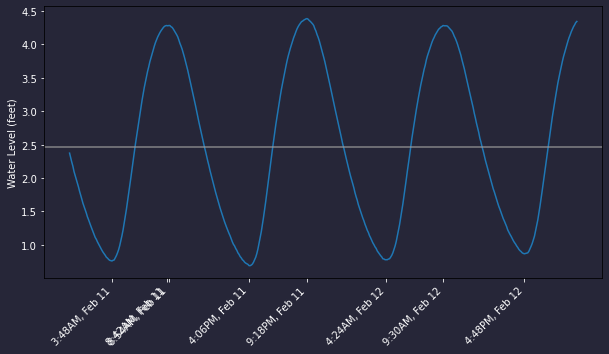

In [14]:
today = datetime.now()
yesterday = today + timedelta(days=-1)
xticks = run_tidal_plot_generation(
    begin_date=yesterday.strftime('%Y%m%d'),
    end_date=today.strftime('%Y%m%d')
)

In [18]:
xticks.sort_values('t', inplace=True)

# Initialize a list to keep track of indexes to keep
indexes_to_keep = []

prev_t = None
for idx, row in xticks.iterrows():
    if prev_t is None or (row['t'] - prev_t) > timedelta(minutes=20):
        indexes_to_keep.append(idx)
    prev_t = row['t']

# Filter the DataFrame to keep only selected rows
filtered_xticks = xticks.loc[indexes_to_keep]
filtered_xticks

,t,v,s,f,q,t_display
38,2024-02-11 03:48:00,0.760,0.003,"0,0,0,0",p,"3:48AM, Feb 11"
87,2024-02-11 08:42:00,4.281,0.003,"0,0,0,0",p,"8:42AM, Feb 11"
161,2024-02-11 16:06:00,0.690,0.003,"1,0,0,0",p,"4:06PM, Feb 11"
213,2024-02-11 21:18:00,4.385,0.003,"0,0,0,0",p,"9:18PM, Feb 11"
284,2024-02-12 04:24:00,0.779,0.003,"1,0,0,0",p,"4:24AM, Feb 12"
335,2024-02-12 09:30:00,4.281,0.003,"0,0,0,0",p,"9:30AM, Feb 12"
408,2024-02-12 16:48:00,0.868,0.003,"0,0,0,0",p,"4:48PM, Feb 12"
